In [51]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

Model Options:
- Resnet
- our own CNN
- Logistic

In [ ]:

transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [49]:
# Load the entire dataset
image_dir = "./cell_images"
full_dataset = datasets.ImageFolder(image_dir)

# Split the dataset into train and test sets
train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

# Create subsets for train and test
train_subset = torch.utils.data.Subset(full_dataset, train_indices)
test_subset = torch.utils.data.Subset(full_dataset, test_indices)

# Apply transformations to train and test subsets
train_subset.dataset.transform = transform
test_subset.dataset.transform = transform

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

# Check the number of images in train and test sets
print("Number of images in train set:", len(train_subset))
print("Number of images in test set:", len(test_subset))

Number of images in train set: 22046
Number of images in test set: 5512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


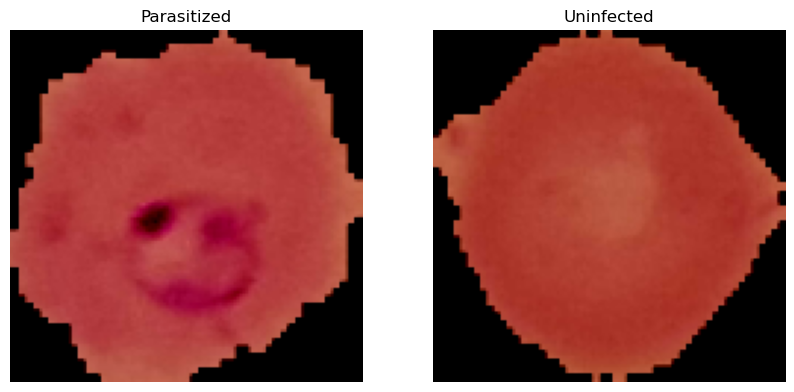

In [46]:
# Assuming 'full_dataset' is already loaded with ImageFolder
class_names = full_dataset.classes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, class_name in enumerate(class_names):
    # Find an image in the current class
    for img, label in full_dataset:
        if label == i:
            ax = axes[i]
            ax.set_title(class_name)
            ax.imshow(img.permute(1, 2, 0))  # Convert from PyTorch format to image format
            ax.axis('off')
            break  # Break after finding one image per class

plt.show()


In [52]:
model = models.resnet50(pretrained=True)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/saunaksingh/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:03<00:00, 32.8MB/s]


In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

In [ ]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    total_count = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        total_count += 1

    train_losses.append(running_loss / total_count)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    # print('Training accuracy: %d %%' % train_accuracy)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    # print('Accuracy of the network on the 10000 test images: %d %%' % test_accuracy)

print('Finished Training')

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()